In [14]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    classification_report
)

from scipy import sparse
from xgboost import XGBClassifier
import joblib

## Model training by cells

In [15]:
# ---------------------------------------------------------------------
# 1. Paths & constants
# ---------------------------------------------------------------------
SUFFIX = "_opioid_sample1M_grace15_minspell7_ae_censoring"
BASE = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50")

demographics_path = BASE / "demographics_opioid_sample1M.parquet"
split_spells_path = BASE / f"split_spells{SUFFIX}.parquet"
icd10_path = BASE / f"icd10_codes_from_spells{SUFFIX}_clustered.parquet"

AE_WINDOW_DAYS = 30

# ---------------------------------------------------------------------
# 2. Load data
# ---------------------------------------------------------------------
print("Loading data...")
dem = pd.read_parquet(demographics_path)
spells = pd.read_parquet(split_spells_path)
icd = pd.read_parquet(icd10_path)

print(f"dem shape:    {dem.shape}")
print(f"spells shape: {spells.shape}")
print(f"icd shape:    {icd.shape}")

# ---------------------------------------------------------------------
# 3. Basic cleaning / filters
# ---------------------------------------------------------------------

# Ensure date columns are datetime
date_cols = ["entry_date", "raw_exit_date", "extended_exit_date",
             "followup_end_date", "first_ae_date"]
for c in date_cols:
    if c in spells.columns:
        spells[c] = pd.to_datetime(spells[c])

# Filter spells: keep only drug_combo with len >= 3
# (and make sure drug_combo is actually a list)
spells = spells[spells["drug_combo"].map(len) >= 3]
print(f"spells after drug_combo filter: {spells.shape}")

# ---------------------------------------------------------------------
# 4. Clean AE variable & define AE within 30 days
# ---------------------------------------------------------------------
# AE within 30 days of entry_date
spells["ae_within_30d"] = (
    spells["had_ae"]
    & (spells["first_ae_date"] <= spells["entry_date"] + pd.Timedelta(days=AE_WINDOW_DAYS))
)

# How many AEs?
print("Number of spells with AE", spells["had_ae"].sum())

# Binary label
spells["y"] = spells["ae_within_30d"].astype(int)
print("Number of AE within 30 days:", spells["y"].sum())
print("AE within 30 days rate:", spells["y"].mean())


Loading data...
dem shape:    (164987, 6)
spells shape: (359356, 14)
icd shape:    (248116, 4)
spells after drug_combo filter: (316173, 14)
Number of spells with AE 3433
Number of AE within 30 days: 2989
AE within 30 days rate: 0.009453685166032521


In [3]:
#this check ensures that all rows with the same MemberUID in demographics are identical, but there are a lot of Nans in birthyear and that is why we do not use the variables.
# Check for duplicate MemberUIDs with non-identical rows
duplicates = dem[dem.duplicated(subset=['MemberUID'], keep=False)]
count_test = 0
print(f"Number of duplicate MemberUIDs in demographics: {duplicates['MemberUID'].nunique()}")
for member_id, group in duplicates.groupby('MemberUID'):
    if not group.drop(columns=['MemberUID']).nunique(dropna=False).le(1).all():
        print(f"Non-identical rows found for MemberUID {member_id}:")
        print(group)
        count_test += 1

    if count_test == 10:
        break

if count_test == 0:
    print("All duplicate MemberUIDs have identical rows.")

# Print how many rows have NaN or None in birthyear
nan_birthyear_count = dem['birthyear'].isna().sum()
gender_none_count = dem['gendercode'].isna().sum()
print(f"Number of rows with NaN in birthyear: {nan_birthyear_count}")
print(f"Number of rows with None in gender: {gender_none_count}")

Number of duplicate MemberUIDs in demographics: 0
All duplicate MemberUIDs have identical rows.
Number of rows with NaN in birthyear: 170
Number of rows with None in gender: 0


In [16]:
# ---------------------------------------------------------------------
# 5. Merge demographics + spells + icd codes
# ---------------------------------------------------------------------
# icd has: ['MemberUID', 'spell_id', 'split_seq', 'icd10_codes']
# spells has: ['MemberUID', 'spell_id', 'split_seq', ...]
# demographics has: ['MemberUID', 'birthyear', 'gendercode',
#                    'raceethnicitytypecode', 'zip3value', 'statecode']

print("Merging tables...")
dem = dem.drop_duplicates(subset=["MemberUID"], keep="first") # ensure unique MemberUIDs in dem
df = spells.merge(dem, on="MemberUID", how="left")
print("After merging demographics, df shape:", df.shape)
df = df.merge(icd, on=["MemberUID", "spell_id", "split_seq"], how="left")

print("Combined df shape:", df.shape)
print("Number of AE within 30 days after merge:", df["y"].sum())
# Print how many rows have NaN or None in birthyear
nan_birthyear_count = df['birthyear'].isna().sum()
gender_none_count = df['gendercode'].isna().sum()
print(f"Number of rows with NaN in birthyear: {nan_birthyear_count}")
print(f"Number of rows with None in gender: {gender_none_count}")

# ---------------------------------------------------------------------
# 6. Simple feature engineering - SKIP FOR NOW
# ---------------------------------------------------------------------
# Age at spell entry
df["age"] = df["entry_date"].dt.year - df["birthyear"]

# You can add more later (e.g., spell_length_days, utilization, etc.)
numeric_cols = ["age"]
for col in numeric_cols:
    if col not in df.columns:
        print(f"Warning: numeric col {col} not in df, dropping from list.")
numeric_cols = [c for c in numeric_cols if c in df.columns]

# Categorical demographics
cat_cols = ["gendercode", "raceethnicitytypecode"]

# Drop rows with missing essential info for now
df = df.dropna(subset=["age", "gendercode"])
print("Number of AE within 30 days after dropping missing essential info:", df["y"].sum())

# ---------------------------------------------------------------------
# 7. Multi-hot encode drugs & ICD10 groups
# ---------------------------------------------------------------------
# Ensure icd10_codes is list-like; replace NaNs with empty list
def to_list_or_empty(x):
    # already a proper list/tuple
    if isinstance(x, (list, tuple)):
        return list(x)
    
    # numpy array from parquet
    if isinstance(x, np.ndarray):
        return x.tolist()
    
    # explicit None
    if x is None:
        return []
    
    # pandas NA / NaN scalars
    try:
        if pd.isna(x):
            return []
    except TypeError:
        # pd.isna on weird types (like arrays) would error,
        # but we've already handled arrays above.
        pass
    
    # fallback: treat as single code
    return [x]

df["icd10_codes"] = df["icd10_codes"].apply(to_list_or_empty)

# drug_combo is already list-like from earlier filter
df["drug_combo"] = df["drug_combo"].apply(lambda x: list(x))

df["num_drugs_in_spell"] = df["drug_combo"].apply(len)
df["num_icd10_codes"] = df["icd10_codes"].apply(len)
numeric_cols.extend(["num_drugs_in_spell", "num_icd10_codes"])

print("Fitting MultiLabelBinarizer for drugs...")
mlb_drugs = MultiLabelBinarizer(sparse_output=True)
X_drugs = mlb_drugs.fit_transform(df["drug_combo"])

print("Number of drug classes:", len(mlb_drugs.classes_))

print("Fitting MultiLabelBinarizer for ICD10 groups...")
mlb_icd = MultiLabelBinarizer(sparse_output=True)
X_icd = mlb_icd.fit_transform(df["icd10_codes"])

print("Number of ICD10 groups:", len(mlb_icd.classes_))

# ---------------------------------------------------------------------
# 8. One-hot encode demographics & combine all features
# ---------------------------------------------------------------------
print("One-hot encoding demographics...")
X_base = df[numeric_cols + cat_cols].copy()

# Fill numeric NaNs with median
for c in numeric_cols:
    X_base[c] = X_base[c].fillna(X_base[c].median())

X_base = pd.get_dummies(X_base, columns=cat_cols, dummy_na=True)

# Make sure everything is numeric and not object
X_base = X_base.apply(pd.to_numeric, errors="coerce").fillna(0).astype("float32")

# Convert base to sparse and hstack with drugs & icd
X_base_sparse = sparse.csr_matrix(X_base.values)

print("Stacking feature matrices...")
# X = sparse.hstack([X_drugs, X_icd]).tocsr()
X = sparse.hstack([X_base_sparse, X_drugs, X_icd]).tocsr()
y = df["y"].values

print("Final feature matrix shape:", X.shape)

# ---------------------------------------------------------------------
# 9. Train/validation split (stratified)
# ---------------------------------------------------------------------
print("Splitting train/validation...")
X_train, X_valid, y_train, y_valid = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
print(f"Train positives: {pos}, negatives: {neg}, scale_pos_weight: {scale_pos_weight:.2f}")

Merging tables...
After merging demographics, df shape: (316173, 21)
Combined df shape: (316173, 22)
Number of AE within 30 days after merge: 2989
Number of rows with NaN in birthyear: 759
Number of rows with None in gender: 0
Number of AE within 30 days after dropping missing essential info: 2983
Fitting MultiLabelBinarizer for drugs...
Number of drug classes: 193
Fitting MultiLabelBinarizer for ICD10 groups...
Number of ICD10 groups: 1864
One-hot encoding demographics...
Stacking feature matrices...
Final feature matrix shape: (315414, 2071)
Splitting train/validation...
Train positives: 2386, negatives: 249945, scale_pos_weight: 104.75


In [17]:
# ---------------------------------------------------------------------
# 10. Train XGBoost model (simple baseline)
# ---------------------------------------------------------------------
print("Training XGBoost...")
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    scale_pos_weight=scale_pos_weight,   # keep as neg/pos for now
    max_depth=4,                         # was 5
    min_child_weight=8,                  # was 5
    learning_rate=0.05,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    n_jobs=8,
)

model.fit(
    X_train,
    y_train,
    eval_set=[(X_valid, y_valid)],
    verbose=50,
    # early_stopping_rounds=50
)

Training XGBoost...
[0]	validation_0-aucpr:0.02498
[50]	validation_0-aucpr:0.03267
[100]	validation_0-aucpr:0.03608
[150]	validation_0-aucpr:0.03678
[200]	validation_0-aucpr:0.03666
[250]	validation_0-aucpr:0.03655
[300]	validation_0-aucpr:0.03763
[350]	validation_0-aucpr:0.03776
[399]	validation_0-aucpr:0.03761


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'aucpr'


In [19]:
# ---------------------------------------------------------------------
# 11. Evaluation
# ---------------------------------------------------------------------
from datetime import datetime


print("Evaluating...")
y_valid_proba = model.predict_proba(X_valid)[:, 1]

auc_pr = average_precision_score(y_valid, y_valid_proba)
auc_roc = roc_auc_score(y_valid, y_valid_proba)

print(f"AUC-PR:  {auc_pr:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Choose an initial probability threshold (you'll tune this later)
threshold = 0.01
y_valid_pred = (y_valid_proba >= threshold).astype(int)

print(f"\nClassification report at threshold = {threshold}:")
report_str = classification_report(y_valid, y_valid_pred, digits=3)
print(report_str)

log_path = f"../../training/training_log{SUFFIX}.txt"
with open(log_path, "a") as f:
    f.write("\n" + "="*60 + "\n")
    f.write(f"Run description: SINGLE run from notebook\n")
    f.write(f"Run time: {datetime.now().isoformat(timespec='seconds')}\n")
    f.write(f"SUFFIX: {SUFFIX}\n")
    f.write(f"AUC-PR:  {auc_pr:.4f}\n")
    f.write(f"AUC-ROC: {auc_roc:.4f}\n")
    f.write(f"Threshold: {threshold}\n")
    f.write(f"Train shape: {X_train.shape}, Valid shape: {X_valid.shape}\n")
    f.write("Classification report:\n")
    f.write(report_str + "\n")

# ---------------------------------------------------------------------
# 12. Save model & encoders
# ---------------------------------------------------------------------
print("Saving model and encoders...")
joblib.dump(model, BASE / f"xgb_ae30d_model{SUFFIX}.joblib")
joblib.dump(mlb_drugs, BASE / "mlb_drugs.joblib")
joblib.dump(mlb_icd, BASE / "mlb_icd.joblib")
# joblib.dump(X_base.columns.tolist(), BASE / "base_feature_columns.joblib")

print("Done.")

Evaluating...
AUC-PR:  0.0674
AUC-ROC: 0.8116

Classification report at threshold = 0.01:
              precision    recall  f1-score   support

           0      1.000     0.000     0.001     62486
           1      0.009     1.000     0.019       597

    accuracy                          0.010     63083
   macro avg      0.505     0.500     0.010     63083
weighted avg      0.991     0.010     0.001     63083

Saving model and encoders...
Done.


## Evaluating the results

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    precision_recall_curve
)

import joblib

BASE = Path("/n/scratch/users/b/bef299/polypharmacy_project_fhd8SDd3U50")
SUFFIX = "_opioid_sample1M_grace15_minspell7_ae_censoring"

# Load model and encoders
# model = joblib.load(BASE / f"xgb_ae30d_model_best{SUFFIX}.joblib")
# mlb_drugs = joblib.load(BASE / "mlb_drugs.joblib")
# mlb_icd = joblib.load(BASE / "mlb_icd.joblib")

print("Model and encoders loaded.")


Model and encoders loaded.


In [20]:
print(X_valid.shape, y_valid.shape)

(63083, 2071) (63083,)


In [21]:
# Predict probabilities on validation set
y_valid_proba = model.predict_proba(X_valid)[:, 1]

auc_pr = average_precision_score(y_valid, y_valid_proba)
auc_roc = roc_auc_score(y_valid, y_valid_proba)

print(f"AUC-PR:  {auc_pr:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

print("Mean predicted probability:", y_valid_proba.mean())
print("Top 5 predicted probabilities:", np.sort(y_valid_proba)[-5:])


AUC-PR:  0.0674
AUC-ROC: 0.8116
Mean predicted probability: 0.30399632
Top 5 predicted probabilities: [0.980721   0.98117995 0.9823391  0.9878511  0.9911542 ]


In [22]:
from sklearn.metrics import f1_score

prec, rec, thr = precision_recall_curve(y_valid, y_valid_proba)

# Remove the last threshold element (PR curve has len(thr) = len(prec) - 1)
prec = prec[:-1]
rec = rec[:-1]
thr = thr

# F1-optimal threshold
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = f1.argmax()
best_thr_f1 = thr[best_idx]

print(f"F1-max threshold: {best_thr_f1:.4f}")
print(f"Precision at F1-max: {prec[best_idx]:.4f}")
print(f"Recall at F1-max:    {rec[best_idx]:.4f}")
print(f"F1-max:              {f1[best_idx]:.4f}")

def find_threshold_for_precision(target_precision):
    # find first threshold where precision >= target_precision
    idx = np.where(prec >= target_precision)[0]
    if len(idx) == 0:
        return None
    i = idx[0]
    return thr[i], prec[i], rec[i]

for p_target in [0.05, 0.10, 0.20]:
    res = find_threshold_for_precision(p_target)
    if res is None:
        print(f"No threshold achieves precision >= {p_target}")
    else:
        t, p, r = res
        print(f"Precision ≥ {p_target:.2f}: threshold={t:.4f}, precision={p:.4f}, recall={r:.4f}")


F1-max threshold: 0.8626
Precision at F1-max: 0.1217
Recall at F1-max:    0.1859
F1-max:              0.1471
Precision ≥ 0.05: threshold=0.5694, precision=0.0500, recall=0.4891
Precision ≥ 0.10: threshold=0.8251, precision=0.1000, recall=0.2027
Precision ≥ 0.20: threshold=0.9548, precision=0.2000, recall=0.0268


In [23]:
def precision_recall_at_k(y_true, y_proba, frac):
    n = len(y_true)
    k = int(frac * n)
    idx = np.argsort(-y_proba)[:k]
    y_top = y_true[idx]
    precision_k = y_top.mean()            # PPV in the top frac
    recall_k = y_top.sum() / y_true.sum() # proportion of all events captured
    return precision_k, recall_k, k

for frac in [0.001,0.01, 0.05, 0.10]:
    p_k, r_k, k = precision_recall_at_k(y_valid, y_valid_proba, frac)
    print(f"Top {int(frac*100)}% (n={k}):")
    print(f"  Precision@k: {p_k:.4f}")
    print(f"  Recall@k:    {r_k:.4f}")
    print()

baseline_rate = y_valid.mean()
print("Baseline AE rate:", baseline_rate)

p_5, r_5, k_5 = precision_recall_at_k(y_valid, y_valid_proba, 0.05)
print("Enrichment in top 5%:", p_5 / baseline_rate)

Top 0% (n=63):
  Precision@k: 0.2381
  Recall@k:    0.0251

Top 1% (n=630):
  Precision@k: 0.1302
  Recall@k:    0.1374

Top 5% (n=3154):
  Precision@k: 0.0679
  Recall@k:    0.3585

Top 10% (n=6308):
  Precision@k: 0.0479
  Recall@k:    0.5059

Baseline AE rate: 0.00946372239747634
Enrichment in top 5%: 7.169520186007187


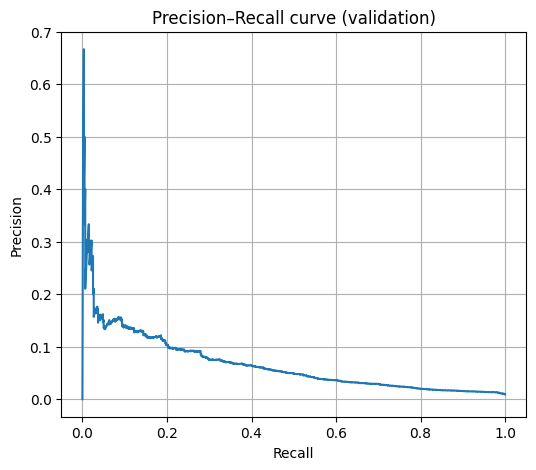

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall curve (validation)")
plt.grid(True)
plt.show()


In [25]:
# If you still have X_base in memory:
try:
    base_feature_names = X_base.columns.tolist()
except NameError:
    # If not, load them from disk if you saved them earlier,
    # or reconstruct in the same way as in your training script.
    base_feature_names = joblib.load(BASE / "base_feature_columns.joblib")

drug_feature_names = [f"drug::{c}" for c in mlb_drugs.classes_]
icd_feature_names = [f"icd::{c}" for c in mlb_icd.classes_]

feature_names = base_feature_names + drug_feature_names + icd_feature_names
len(feature_names), X_valid.shape[1]


(2071, 2071)

In [26]:
import shap

# For Jupyter notebooks
shap.initjs()

# Sample a subset of validation rows for SHAP to keep it manageable
n_shap = min(5000, X_valid.shape[0])
rng = np.random.default_rng(42)
subset_idx = rng.choice(X_valid.shape[0], size=n_shap, replace=False)

X_valid_shap = X_valid[subset_idx]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_valid_shap)

print("SHAP values shape:", np.array(shap_values).shape)


SHAP values shape: (5000, 2071)


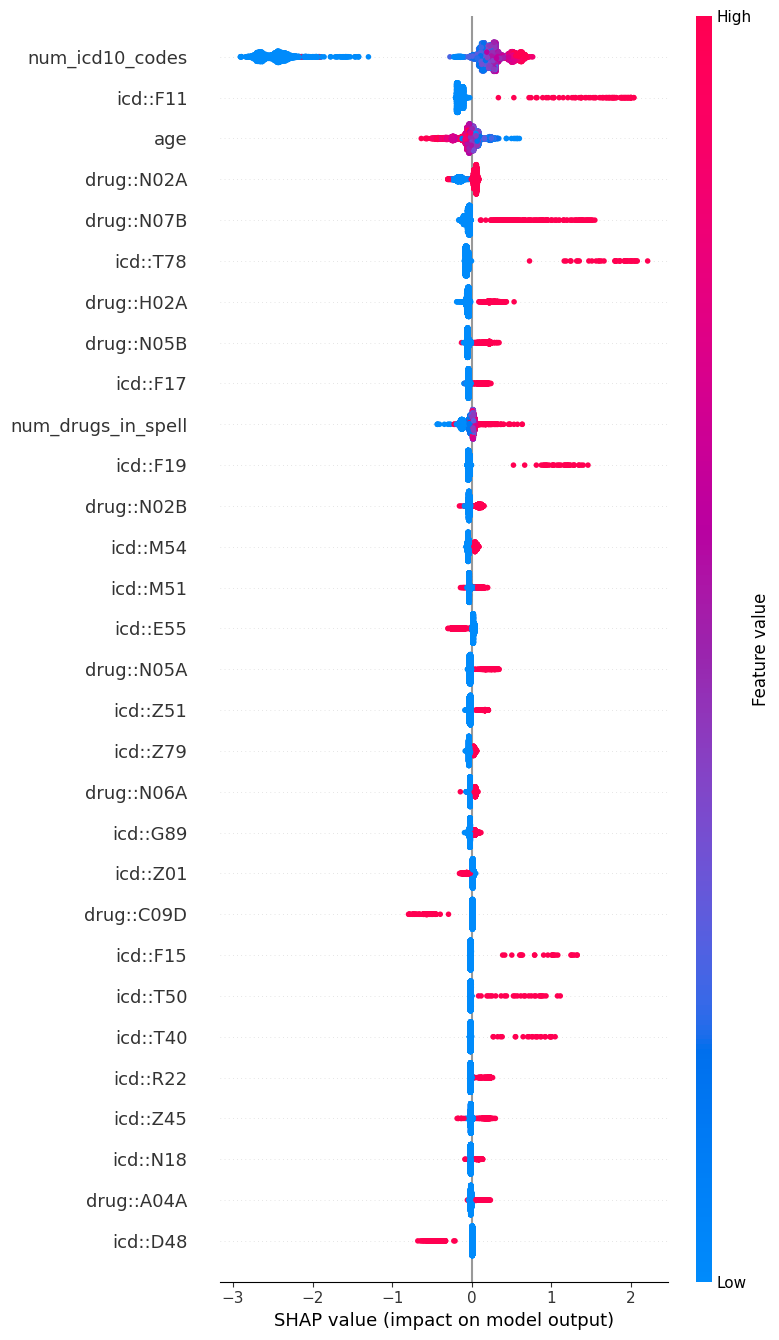

In [27]:
# Convert sparse to dense for plotting if needed (5000 x ~2000 should be OK)
X_valid_shap_dense = X_valid_shap.toarray()

shap.summary_plot(
    shap_values,
    X_valid_shap_dense,
    feature_names=feature_names,
    max_display=30  # show top 30 features
)


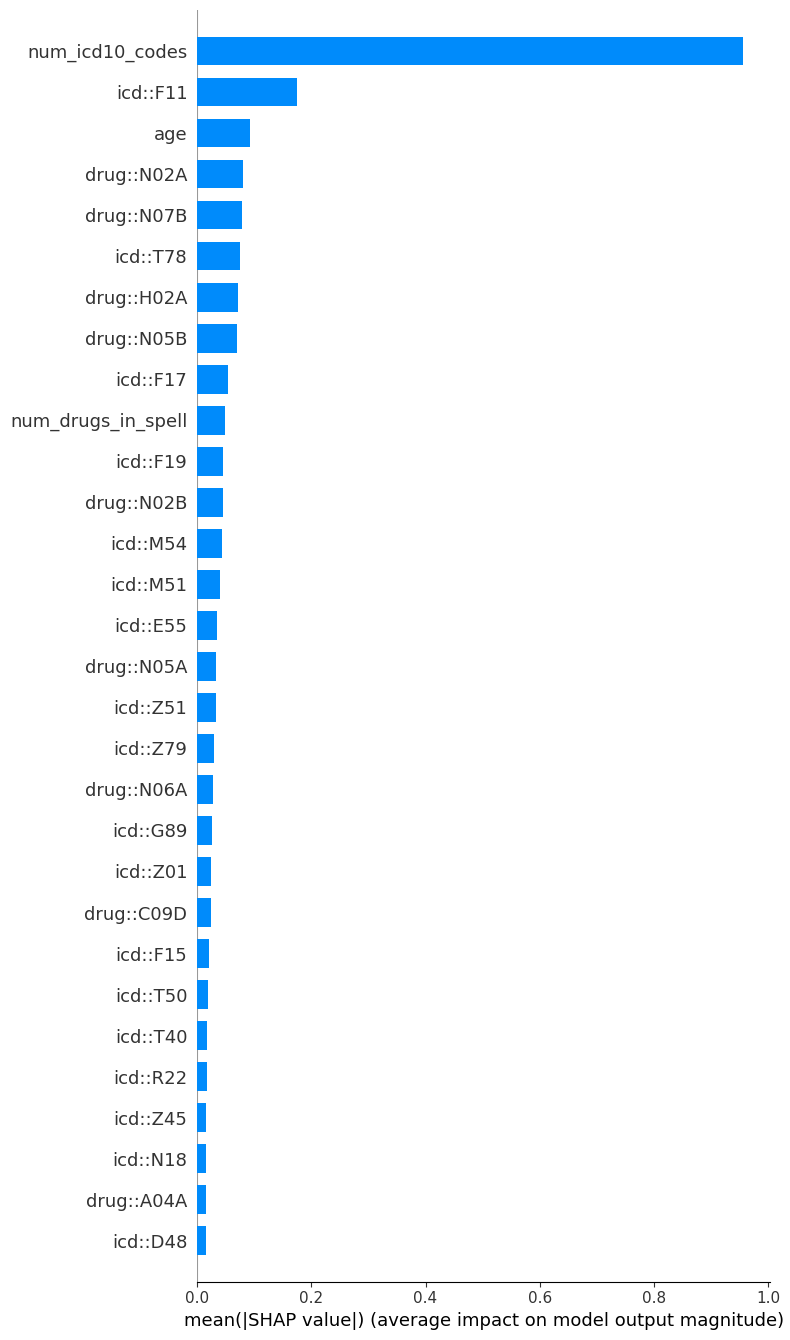

In [28]:
shap.summary_plot(
    shap_values,
    X_valid_shap_dense,
    feature_names=feature_names,
    max_display=30,
    plot_type="bar"
)
